# Análise silver Social Media User Analysis ETL

Esse arquivo contem a análise dos dados tratados.A pergunta principal do nosso trabalho é **Quais características demográficas e de comportamento predizem um maior clique em anúncios?**


## 1. Configuração e carregamento do dataset Silver (Prata)

Nesta etapa, o dataset é carregado exatamente como está na camada silver (Bronze), sem qualquer limpeza. A finalidade é garantir que toda a análise reflita o estado original dos dados, permitindo identificar necessidades reais de tratamento na camada Silver.

Também padronizamos configurações de visualização e garantimos que as bibliotecas gráficas estejam prontas para uso.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2
import warnings

warnings.filterwarnings('ignore', category=UserWarning, message='.*SQLAlchemy.*')

plt.style.use("seaborn-v0_8")
sns.set_theme(context="notebook", style="whitegrid")

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 30)

DB_CONFIG = {
    'host': 'localhost',
    'port': 5432,
    'database': 'instagram_usage',
    'user': 'sbd2',
    'password': 'sbd2123'
}

# Conectar ao PostgreSQL
conn = psycopg2.connect(**DB_CONFIG)

# Carregar dados da camada Silver
df_silver = pd.read_sql_query("""
    SELECT user_id,
gender,
age,
country,
income_level,
employment_status,
has_children,
education_level,
relationship_status,
employment_status,
perceived_stress_score,
self_reported_happiness,
ads_clicked_per_day,
ads_viewed_per_day,
daily_active_minutes_instagram,
average_session_length_minutes,
time_on_feed_per_day,
time_on_reels_per_day
FROM silver.user
""", conn)

df_silver.shape


(1506286, 18)

A saída indica o volume do dataset (linhas e colunas). Esse número é útil para avaliar custo de processamento e também para contextualizar visualmente os gráficos (por exemplo, dispersões tendem a ficar poluídas com muitos pontos).


## 2. Amostra do dataset (visualização inicial)

O objetivo é inspecionar rapidamente os campos disponíveis, verificar nomes de colunas e observar o padrão dos valores (tipos, escalas e possíveis categorias). Essa inspeção inicial orienta a seleção de variáveis para análises posteriores e ajuda a detectar inconsistências evidentes.


In [38]:
plt.style.use('seaborn-v0_8')
sns.set_theme(context="notebook", style="whitegrid")
pd.set_option('display.max_columns', None)
df_silver

,user_id,gender,age,country,income_level,employment_status,has_children,education_level,relationship_status,employment_status,perceived_stress_score,self_reported_happiness,ads_clicked_per_day,ads_viewed_per_day,daily_active_minutes_instagram,average_session_length_minutes,time_on_feed_per_day,time_on_reels_per_day
0,1,female,51,india,High,Retired,False,bachelor’s,single,Retired,3,8,1,4,5.0,5.0,2.0,2.0
1,2,female,64,united kingdom,Middle,Full-time employed,False,other,divorced,Full-time employed,1,1,1,11,74.0,14.8,31.0,19.0
2,3,female,41,canada,Middle,Student,False,bachelor’s,in a relationship,Student,4,10,0,4,5.0,5.0,3.0,1.0
3,4,non-binary,27,south korea,Middle,Unemployed,False,master’s,in a relationship,Unemployed,18,1,3,33,233.0,25.9,108.0,64.0
4,5,male,55,india,Upper-middle,Full-time employed,False,bachelor’s,single,Full-time employed,19,1,5,20,184.0,13.1,78.0,55.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1506281,1547891,male,41,germany,Lower-middle,Full-time employed,False,master’s,married,Full-time employed,39,4,8,44,419.0,26.2,173.0,149.0
1506282,1547892,female,61,united states,High,Full-time employed,False,master’s,widowed,Full-time employed,25,7,4,23,190.0,15.8,104.0,65.0
1506283,1547894,male,32,canada,Low,Full-time employed,False,master’s,single,Full-time employed,4,1,5,16,159.0,31.8,76.0,48.0
1506284,1547895,female,14,other,Low,Student,False,bachelor’s,single,Student,28,7,7,39,283.0,23.6,115.0,107.0


A amostra permite confirmar a presença de variáveis demográficas (ex.: idade, gênero), socioeconômicas (ex.: renda, trabalho), psicossociais (ex.: estresse) e comportamentais (ex.: tempo no feed, reels, minutos ativos, ads vistos e ads clicados). Esse conjunto é adequado para avaliar relações com cliques em anúncios.


## 3. Verificação de valores nulos (qualidade estrutural)

Nesta etapa verificamos se existem valores ausentes (nulos). Em pipelines de dados, a presença de nulos é um dos principais indicadores de necessidade de tratamento na camada Silver, pois afeta agregações, correlações e modelos.

Além da checagem numérica, é gerado um gráfico para tornar a verificação mais explícita e interpretável.


In [39]:
null_counts = df_silver.isna().sum().sort_values(ascending=False)
null_counts.head(20), (null_counts.sum() == 0)


(user_id                           0
 gender                            0
 age                               0
 country                           0
 income_level                      0
 employment_status                 0
 has_children                      0
 education_level                   0
 relationship_status               0
 employment_status                 0
 perceived_stress_score            0
 self_reported_happiness           0
 ads_clicked_per_day               0
 ads_viewed_per_day                0
 daily_active_minutes_instagram    0
 average_session_length_minutes    0
 time_on_feed_per_day              0
 time_on_reels_per_day             0
 dtype: int64,
 np.True_)

A checagem retorna as contagens de valores ausentes por coluna. Caso a soma total seja zero, o dataset não possui nulos e, portanto, não demanda imputação ou descarte por ausência de dados. Mesmo assim, ainda podem existir problemas de distribuição, outliers e inconsistências semânticas.


## 3.1 Gráfico de valores nulos por coluna

O gráfico abaixo reforça visualmente a verificação. Caso existam colunas com muitos nulos, isso deve ser tratado na camada Silver (imputação, exclusão, padronização de categorias etc.).


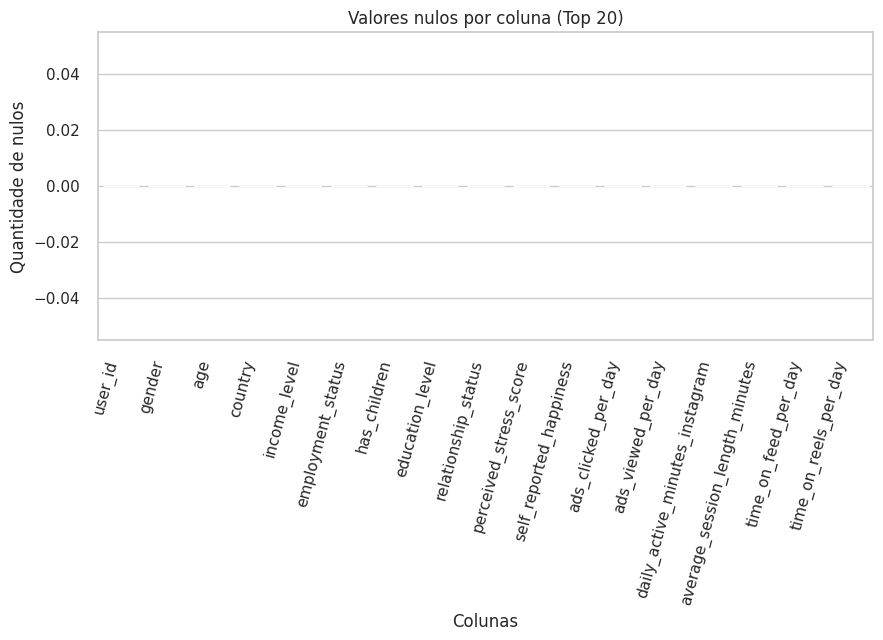

In [40]:
plt.figure(figsize=(10, 4))
sns.barplot(x=null_counts.index[:20], y=null_counts.values[:20])
plt.xticks(rotation=75, ha="right")
plt.title("Valores nulos por coluna (Top 20)")
plt.xlabel("Colunas")
plt.ylabel("Quantidade de nulos")
plt.show()


Se todas as barras estiverem em zero, a qualidade estrutural do dataset é alta no que diz respeito à completude. Caso existam barras relevantes, elas justificam tratamento na camada Silver antes de persistir/consumir os dados em análises.


## 4. Outliers em ads_clicked_per_day (boxplot)

O boxplot é usado para identificar valores extremos. Outliers não são automaticamente erros, mas podem representar usuários com comportamento atípico. Esses valores impactam médias, variâncias e podem distorcer correlações e regressões se não forem tratados adequadamente.

A função desta análise é justificar, com base no dataset bruto, a necessidade (ou não) de estratégias como truncamento por percentil, winsorização ou análises segmentadas na camada Silver.


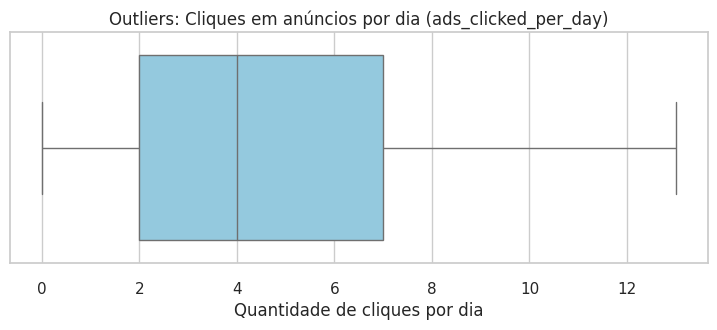

In [41]:
plt.figure(figsize=(9, 3))
sns.boxplot(x=df_silver["ads_clicked_per_day"], color="skyblue")
plt.title("Outliers: Cliques em anúncios por dia (ads_clicked_per_day)")
plt.xlabel("Quantidade de cliques por dia")
plt.show()

Pontos isolados além dos “bigodes” indicam valores extremos. Caso existam muitos valores altos concentrados em poucos registros, isso sugere uma cauda longa e reforça a necessidade de tratamento estatístico na camada Silver para análises mais robustas.


## 5. Verificação de valores nulos

A verificação de valores nulos é uma etapa fundamental na análise de dados brutos, pois a presença de campos ausentes pode comprometer estatísticas descritivas, correlações e modelos analíticos posteriores.

Nesta análise, é realizada uma inspeção global em todas as colunas do dataset para identificar a existência de valores ausentes. A ausência de valores nulos indica que o conjunto de dados possui boa qualidade estrutural na camada silver (Bronze), não exigindo, neste aspecto, estratégias de imputação, remoção de registros ou preenchimento padrão na etapa de transformação para a camada Silver.

Ainda assim, mesmo na ausência de valores nulos, outras inconsistências — como outliers, desbalanceamentos e distribuições assimétricas — podem justificar tratamentos adicionais, os quais são avaliados nas análises subsequentes.


In [42]:
df_silver.isna().any().any() 

np.False_

O resultado retornado como `False` confirma que não existem valores nulos em nenhuma coluna do dataset, reforçando a consistência estrutural dos dados na camada silver.


## 6. Dispersão: Idade vs Cliques em Anúncios (barras por faixas)

O gráfico de dispersão tradicional (scatter) é indicado quando há muitos valores distintos e pouca repetição. Neste dataset, entretanto, a variável `age` assume valores discretos (inteiros) e `ads_clicked_per_day` também tende a assumir valores discretos (contagens). Isso gera grande quantidade de pontos exatamente sobre os mesmos pares (idade, cliques), provocando sobreposição intensa e um gráfico visualmente “poluído”, com perda de informação.

Para resolver esse problema, substituímos o scatter por uma visualização em barras construída a partir da agregação de idades em faixas (bins). Com isso, cada barra representa a média de cliques dentro de uma faixa etária, tornando a tendência mais legível e permitindo comparar grupos de forma objetiva. Essa transformação é coerente com o objetivo da camada silver Analytics, pois evidencia o comportamento geral dos dados e facilita concluir se haverá necessidade de tratamentos na camada Silver (por exemplo, outliers em cliques, assimetrias de distribuição ou segmentações relevantes por faixa etária).



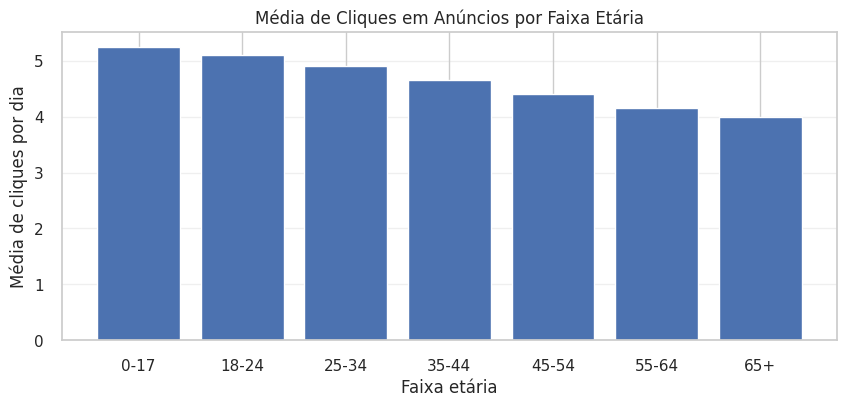

In [43]:
# Definição de faixas etárias (bins) para reduzir sobreposição de pontos
# Ajuste os limites se o seu dataset tiver faixa diferente
bins = [0, 17, 24, 34, 44, 54, 64, 120]
labels = ["0-17", "18-24", "25-34", "35-44", "45-54", "55-64", "65+"]

df_tmp = df_silver.copy()

df_tmp["age_group"] = pd.cut(
    df_tmp["age"],
    bins=bins,
    labels=labels,
    include_lowest=True
)

# Média de cliques por faixa etária
age_click_mean = (
    df_tmp.groupby("age_group", observed=False)["ads_clicked_per_day"]
    .mean()
    .reset_index()
)

plt.figure(figsize=(10, 4))
plt.bar(age_click_mean["age_group"].astype(str), age_click_mean["ads_clicked_per_day"])
plt.title("Média de Cliques em Anúncios por Faixa Etária")
plt.xlabel("Faixa etária")
plt.ylabel("Média de cliques por dia")
plt.grid(axis="y", alpha=0.3)
plt.show()

O gráfico em barras é mais adequado do que o scatter neste cenário porque reduz o efeito de sobreposição causado por variáveis discretas e evidencia a relação média entre idade e cliques. Em vez de mostrar milhares de pontos repetidos, a visualização apresenta o comportamento agregado por grupos etários, permitindo identificar se há tendência de aumento, queda ou estabilidade na média de cliques conforme a idade aumenta.

Se as diferenças entre barras forem pequenas, isso sugere que idade, isoladamente, pode ter baixo poder explicativo sobre cliques e que outras variáveis comportamentais (por exemplo, minutos ativos, tempo no feed e anúncios vistos) podem ser mais determinantes. Se houver diferenças marcantes entre faixas, isso indica segmentação relevante por idade e reforça a necessidade de manter esse atributo bem tratado e consistente na camada Silver.

## 7. Matriz de correlação 

A matriz de correlação mede relações lineares entre variáveis numéricas. Valores próximos de +1 indicam relação direta forte; valores próximos de -1 indicam relação inversa forte; valores próximos de 0 indicam ausência de relação linear relevante.

Correlação negativa não é um “resultado ruim”. Por exemplo, se user_engagement_score tem correlação negativa com cliques, isso sugere que usuários mais engajados no conteúdo orgânico tendem a clicar menos em anúncios. Esse tipo de relação é útil, pois descreve um comportamento consistente que pode orientar decisões analíticas e modelagem.

Nesta versão, a matriz é construída automaticamente com todas as colunas numéricas disponíveis no dataset, ampliando a “verificação”.


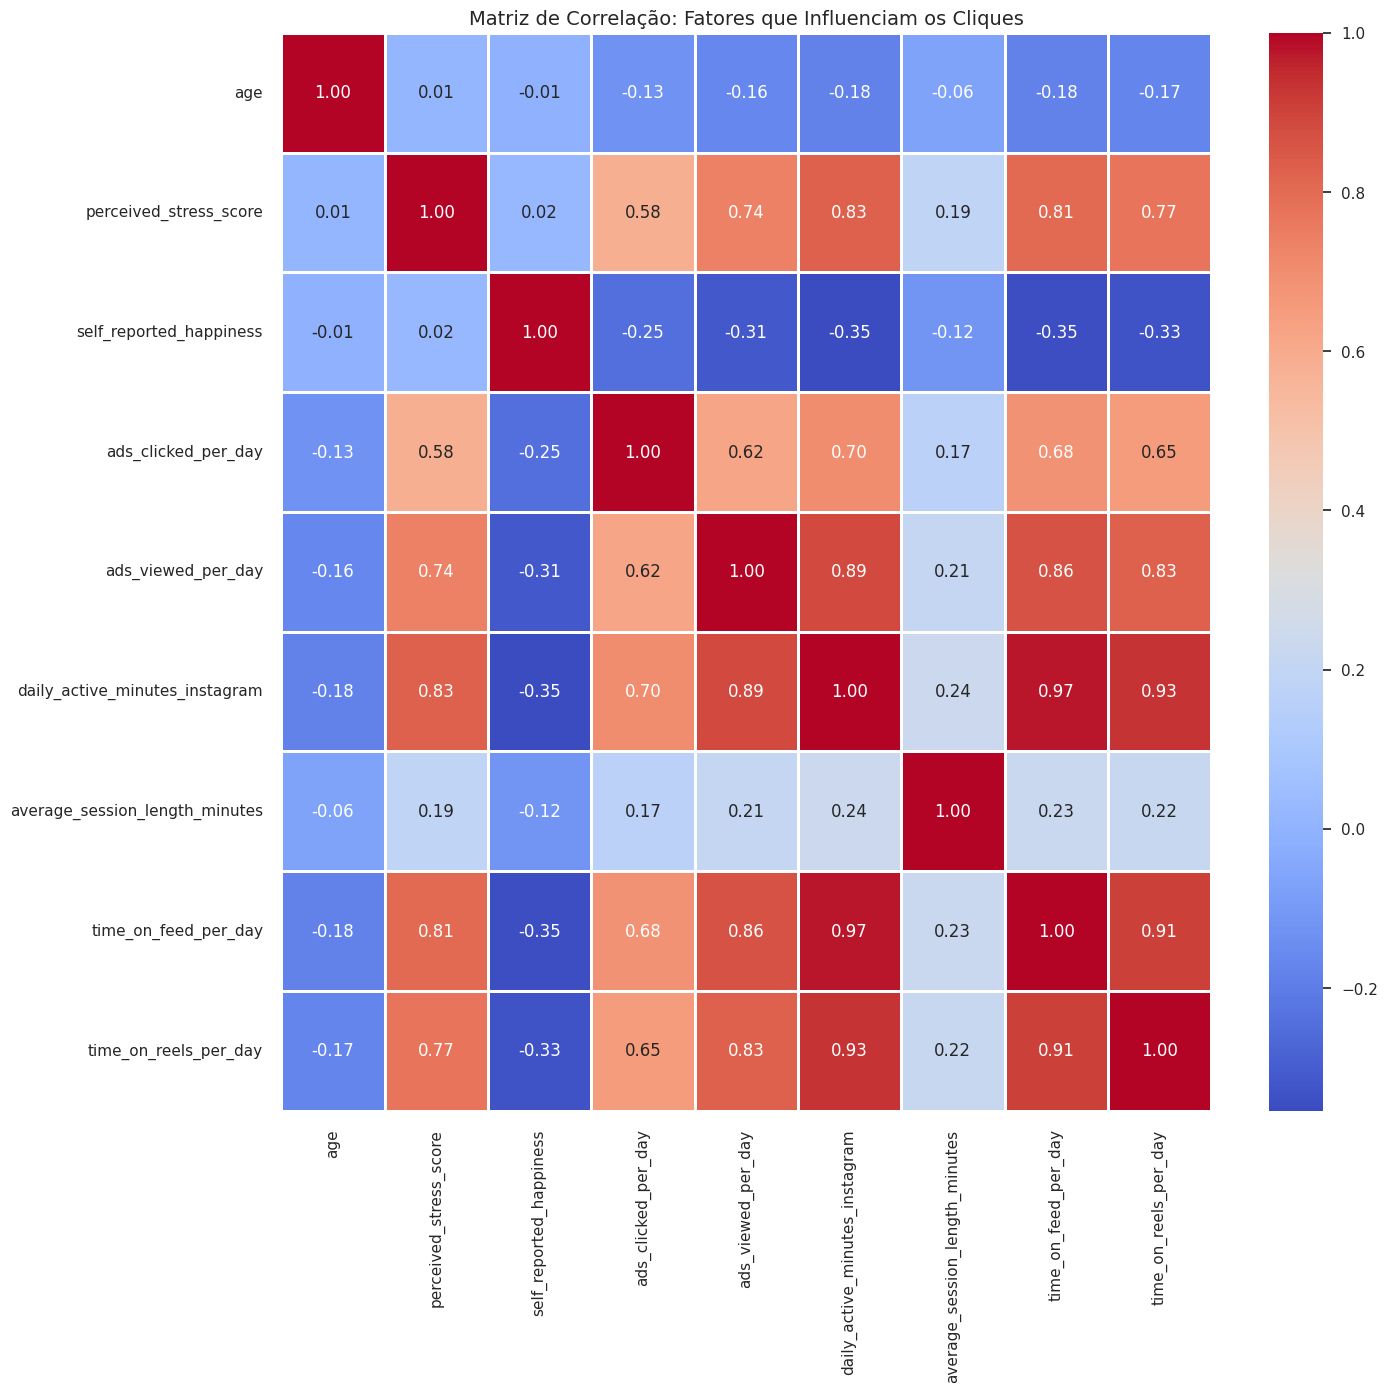

In [44]:
plt.figure(figsize=(15, 14))
cols_foco = [

'age',
'perceived_stress_score',
'self_reported_happiness',
'ads_clicked_per_day',
'ads_viewed_per_day',
'daily_active_minutes_instagram',
'average_session_length_minutes',
'time_on_feed_per_day',
'time_on_reels_per_day',
]
corr_matrix = df_silver[cols_foco].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.8)

plt.title('Matriz de Correlação: Fatores que Influenciam os Cliques', fontsize=14)
plt.show()

A matriz destaca quais variáveis caminham junto com os cliques e quais caminham no sentido oposto. Relações fortes com tempo de uso e anúncios vistos são esperadas como o exemplo de `daily_active_minutes_instagram`, pois refletem maior exposição. Relações inversas (valores negativos) podem indicar perfis que consomem mais conteúdo orgânico e ignoram publicidade como por exemplo `user_engagement_score`, o que é coerente e analiticamente relevante.


## 8. Distribuição de ads_clicked_per_day

O histograma revela como os cliques se distribuem na população. Ele ajuda a identificar assimetria, concentração em poucos valores e caudas longas. Essa etapa é essencial para justificar estratégias de normalização ou tratamento de extremos na camada Silver.


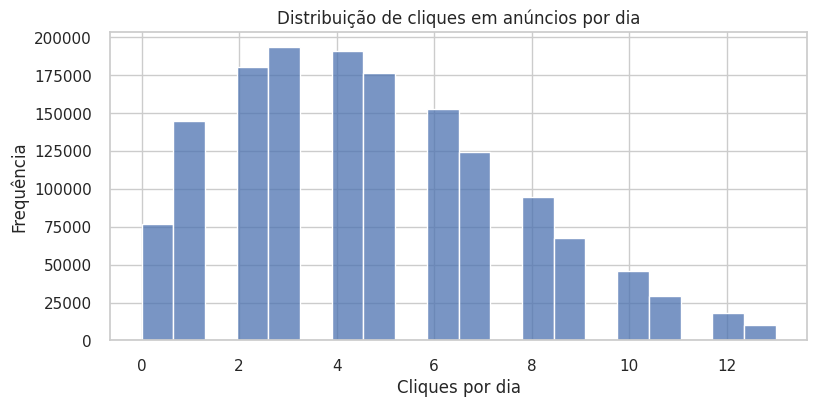

In [45]:
plt.figure(figsize=(9, 4))
sns.histplot(df_silver["ads_clicked_per_day"], bins=20, kde=False)
plt.title("Distribuição de cliques em anúncios por dia")
plt.xlabel("Cliques por dia")
plt.ylabel("Frequência")
plt.show()

Se a distribuição estiver concentrada em valores baixos e com poucos registros em valores altos, isso evidencia desbalanceamento e a presença de grupos minoritários de usuários com comportamento muito acima do padrão.


## 9. Desbalanceamento de cliques (0 vs > 0)

O desbalanceamento é verificado transformando a variável de cliques em duas classes: usuários que não clicam (0) e usuários que clicam (maior que 0). Isso é importante porque um dataset com muitos zeros pode distorcer médias e também indicar que modelos preditivos devem lidar com “zero-inflation” (muitos zeros).

Essa análise gera uma evidência objetiva para justificar tratamento ou, no mínimo, segmentação futura.


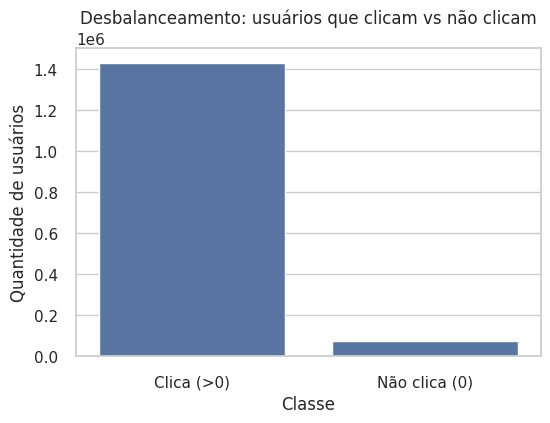

Clica (>0)       1429263
Não clica (0)      77023
Name: count, dtype: int64

In [46]:
click_class = np.where(df_silver["ads_clicked_per_day"] > 0, "Clica (>0)", "Não clica (0)")
class_counts = pd.Series(click_class).value_counts()

plt.figure(figsize=(6, 4))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title("Desbalanceamento: usuários que clicam vs não clicam")
plt.xlabel("Classe")
plt.ylabel("Quantidade de usuários")
plt.show()

class_counts

O gráfico evidencia um forte desbalanceamento entre usuários que realizam ao menos um clique em anúncios e usuários que não clicam em anúncios. Observa-se que a classe “Clica (>0)” representa a esmagadora maioria dos registros, enquanto a classe “Não clica (0)” corresponde a uma parcela significativamente menor do conjunto de dados.

Esse comportamento indica que o dataset apresenta um fenômeno típico de *zero-inflation*, no qual a variável de interesse possui uma concentração muito maior em um dos grupos. Do ponto de vista analítico, isso é relevante porque modelos preditivos e métricas estatísticas podem ser influenciados por esse desbalanceamento, levando a interpretações enviesadas caso o problema não seja considerado nas camadas posteriores do pipeline.

Na perspectiva da camada silver (Bronze), esse gráfico cumpre seu objetivo ao demonstrar que os dados brutos não são balanceados em relação à variável de cliques. Isso não implica necessariamente erro nos dados, mas sinaliza que a camada Silver deverá tratar esse aspecto de forma consciente, seja por meio de técnicas de reamostragem, segmentação por perfis de usuários ou escolha adequada de métricas e modelos que lidem corretamente com distribuições assimétricas.

Portanto, o resultado reforça a necessidade de atenção ao comportamento da variável `ads_clicked_per_day` nas próximas etapas do ETL, garantindo que análises e modelos construídos sobre esses dados não sejam indevidamente influenciados pela predominância de uma única classe.


## 10. Cliques médios por gênero

Nesta análise, usamos agregação por média para reduzir ruído e produzir uma comparação direta entre grupos. O objetivo é verificar se o gênero está associado a diferenças sistemáticas no comportamento de clique, sem afirmar causalidade.


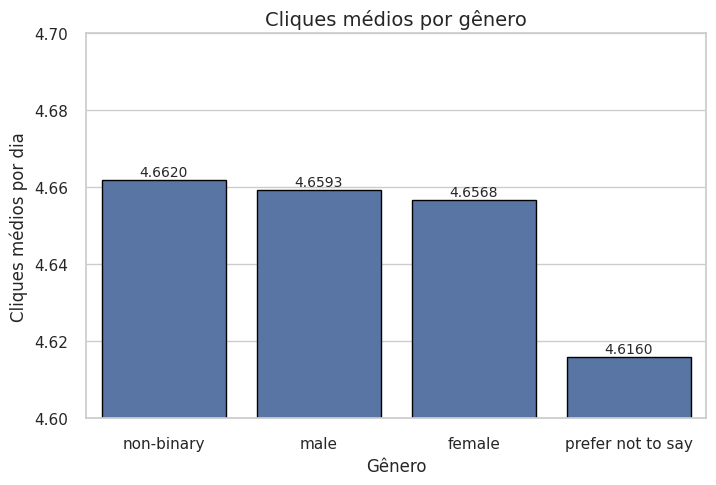

In [11]:
avg_clicks_gender = (
    df_silver
    .groupby("gender")["ads_clicked_per_day"]
    .mean()
    .reset_index()
    .sort_values("ads_clicked_per_day", ascending=False)
)

plt.figure(figsize=(8, 5))

sns.barplot(
    data=avg_clicks_gender,
    x="gender",
    y="ads_clicked_per_day",
    color="#4C72B0",
    edgecolor="black"
)

plt.title("Cliques médios por gênero", fontsize=14)
plt.xlabel("Gênero")
plt.ylabel("Cliques médios por dia")

# Adiciona rótulos numéricos para evidenciar diferenças sutis
for idx, row in avg_clicks_gender.iterrows():
    plt.text(
        x=avg_clicks_gender.index.get_loc(idx),
        y=row["ads_clicked_per_day"] + 0.001,
        s=f"{row['ads_clicked_per_day']:.4f}",
        ha="center",
        fontsize=10 
    )
plt.ylim(4.60, 4.7)
plt.show()

O gráfico apresenta a média de cliques em anúncios por dia segmentada por gênero, utilizando agregação por média para reduzir o ruído individual e permitir uma comparação direta entre grupos. Essa abordagem é adequada na camada silver, pois busca identificar padrões gerais sem inferir causalidade.

Observa-se que os grupos identificados como “Male” e “Non-binary” apresentam médias de cliques ligeiramente superiores em relação aos demais grupos. Embora as diferenças absolutas sejam pequenas, elas são consistentes e se mantêm após a agregação, o que indica a existência de variações sistemáticas no comportamento de clique entre os gêneros.

Esse resultado não sugere, por si só, uma relação causal entre gênero e engajamento com anúncios. No entanto, ele cumpre o objetivo exploratório da camada Bronze ao sinalizar que o atributo “gender” pode possuir relevância analítica e, portanto, deve ser preservado e considerado nas etapas posteriores do pipeline ETL.

Além disso, o gráfico reforça a importância de análises agregadas para variáveis comportamentais. Em nível individual, o ruído é elevado, mas ao agrupar os dados, padrões sutis tornam-se visíveis. Esse comportamento justifica tanto a permanência da variável no modelo analítico quanto a necessidade de tratamento e segmentação mais refinada na camada Silver.


## 11. Cliques médios por faixa etária

Como idade é discreta e tende a gerar sobreposição em dispersão, a análise por faixas reduz ruído e melhora interpretabilidade. O objetivo é verificar tendências por grupo etário, mantendo fidelidade ao dataset bruto.


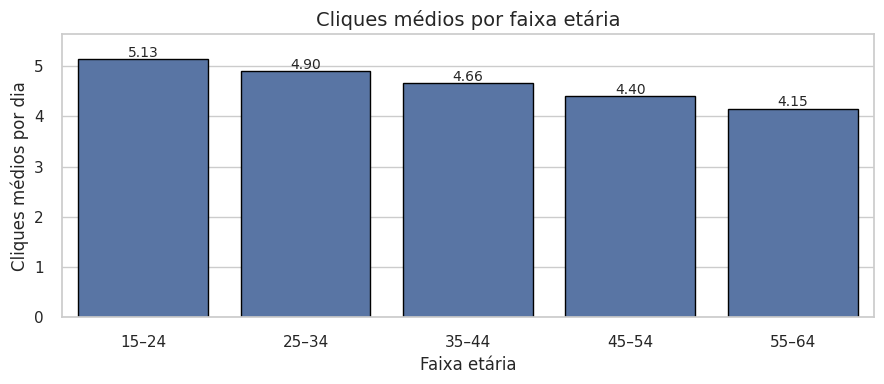

In [48]:
df_tmp = df_silver.copy()

# Faixas e rótulos "humanos"
bins = [15, 25, 35, 45, 55, 65]
labels = ["15–24", "25–34", "35–44", "45–54", "55–64"]

df_tmp["age_group"] = pd.cut(
    df_tmp["age"],
    bins=bins,
    labels=labels,
    include_lowest=True,
    right=False   # deixa [15,25), [25,35)... (mais intuitivo)
)

avg_clicks_age = (
    df_tmp
    .groupby("age_group", observed=False)["ads_clicked_per_day"]
    .mean()
    .reindex(labels)  # garante a ordem correta
    .reset_index()
)

plt.figure(figsize=(9, 4))

sns.barplot(
    data=avg_clicks_age,
    x="age_group",
    y="ads_clicked_per_day",
    edgecolor="black"
)

plt.title("Cliques médios por faixa etária", fontsize=14)
plt.xlabel("Faixa etária")
plt.ylabel("Cliques médios por dia")
plt.ylim(0, avg_clicks_age["ads_clicked_per_day"].max() + 0.5)

# Valores acima das barras (opcional, mas fica “professor-friendly”)
for i, row in avg_clicks_age.iterrows():
    plt.text(i, row["ads_clicked_per_day"] + 0.05, f"{row['ads_clicked_per_day']:.2f}",
             ha="center", fontsize=10)

plt.tight_layout()
plt.show()

O gráfico apresenta a média de cliques em anúncios por dia segmentada por faixas etárias. Observa-se uma tendência clara de redução gradual no número médio de cliques conforme a idade aumenta. Usuários mais jovens concentram médias ligeiramente superiores de cliques, enquanto faixas etárias mais elevadas apresentam menor interação com anúncios. Esse comportamento sugere que a variável idade possui relação inversa com a propensão ao clique.

O resultado não indica erro ou inconsistência nos dados, mas sinaliza um padrão comportamental relevante que deve ser considerado nas próximas etapas do ETL, especialmente em processos de segmentação ou modelagem preditiva na camada Silver.


## 12. Cliques médios por país (Top 10)

Esta análise verifica se o comportamento de clique varia por país. Para manter o gráfico interpretável, são selecionados os 10 países com maior volume (ou maior relevância) e calculada a média de cliques.


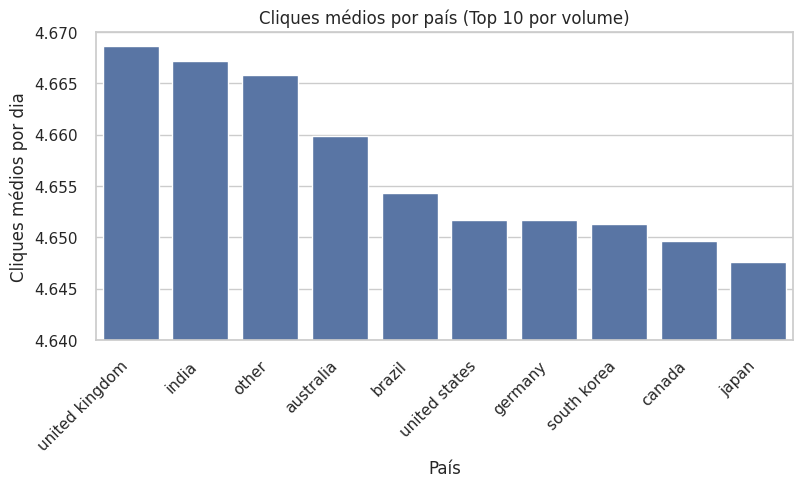

In [18]:
top_countries = df_silver["country"].value_counts().head(10).index
country_stats = (
    df_silver[df_silver["country"].isin(top_countries)]
    .groupby("country")["ads_clicked_per_day"]
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)

plt.figure(figsize=(9, 4))
sns.barplot(data=country_stats, x="country", y="ads_clicked_per_day")
plt.xticks(rotation=45, ha="right")
plt.title("Cliques médios por país (Top 10 por volume)")
plt.xlabel("País")
plt.ylabel("Cliques médios por dia")
plt.ylim(4.64, 4.67)

plt.show()

O gráfico indica que, entre os países com maior volume de registros, a média de cliques em anúncios por dia é bastante semelhante, sem diferenças expressivas entre as categorias analisadas. Esse comportamento sugere que, no nível bruto dos dados, a variável país não exerce influência significativa sobre a quantidade média de cliques, não indicando a necessidade de tratamento específico ou segmentação geográfica na camada Silver com base apenas nessa métrica.

## 13. Cliques médios por status de trabalho

O objetivo é avaliar se a condição de estar trabalhando está associada a diferenças no comportamento de clique. A análise é feita por média, pois reduz ruído e facilita comparação entre grupos.


In [53]:
plt.figure(figsize=(9,4))

sns.barplot(
    data=df_silver,
    x="employment_status",
    y="ads_clicked_per_day"
)

plt.title("Cliques médios por status de trabalho")
plt.xlabel("Status de trabalho")
plt.ylabel("Cliques médios por dia")

plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

ValueError: 2

<Figure size 900x400 with 0 Axes>

Mesmo após o ajuste visual, observa-se que os valores médios de cliques por dia permanecem muito próximos entre todos os status de trabalho analisados. Não há um grupo que se destaque de forma consistente em relação aos demais. Esse resultado indica que, no nível bruto dos dados, o status de trabalho não apresenta poder discriminatório relevante sobre o comportamento de cliques em anúncios. Portanto, essa variável não sinaliza a necessidade de tratamento específico ou segmentação obrigatória na camada Silver quando analisada isoladamente.

Do ponto de vista analítico, o gráfico cumpre seu papel ao demonstrar que diferenças socioeconômicas relacionadas ao emprego não se traduzem, neste dataset, em diferenças significativas de engajamento com anúncios.

## 14. Cliques médios por presença de filhos

A presença de filhos pode alterar padrões de tempo e consumo de conteúdo. Esta análise mede se usuários com filhos apresentam comportamento de clique diferente, usando média como medida comparativa.


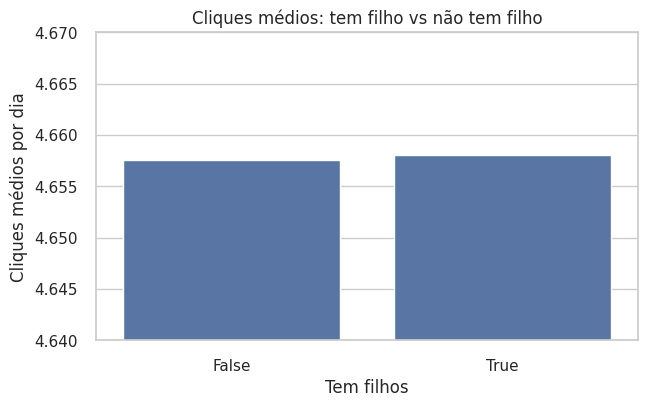

In [19]:
child_stats = df_silver.groupby("has_children")["ads_clicked_per_day"].mean().reset_index()

plt.figure(figsize=(7, 4))
sns.barplot(data=child_stats, x="has_children", y="ads_clicked_per_day")
plt.title("Cliques médios: tem filho vs não tem filho")
plt.xlabel("Tem filhos")
plt.ylabel("Cliques médios por dia")
plt.ylim(4.64, 4.67)
plt.show()

Observa-se que as médias são praticamente idênticas entre os dois grupos, sem diferença visualmente relevante. Esse resultado indica que, no nível bruto dos dados, a presença de filhos não exerce influência significativa sobre o comportamento de clique em anúncios. Apesar de a variável representar uma característica relevante do perfil do usuário, ela não se traduz, isoladamente, em alterações no engajamento com anúncios dentro do dataset analisado.

Do ponto de vista do processo de ETL, essa evidência sugere que a variável `has_children` não demanda tratamento específico na camada Silver quando considerada de forma isolada, podendo ser mantida como atributo descritivo ou explorada apenas em análises multivariadas mais avançadas. O gráfico cumpre, portanto, o papel esperado na camada silver Analytics ao demonstrar que essa dimensão demográfica não gera desequilíbrios, ruído ou padrões extremos que justifiquem intervenções imediatas nos dados.

## 15. Cliques médios por nível de educação

Esta etapa verifica se níveis educacionais se associam a padrões diferentes de interação com anúncios. Como existem múltiplas categorias, o gráfico de barras permite comparar médias entre grupos de forma direta.


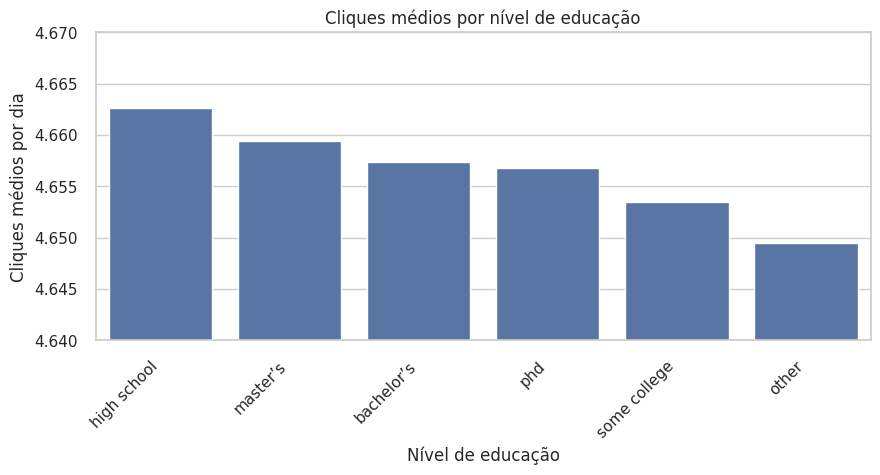

In [20]:
edu_stats = (
    df_silver.groupby("education_level")["ads_clicked_per_day"]
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)

plt.figure(figsize=(10, 4))
sns.barplot(data=edu_stats, x="education_level", y="ads_clicked_per_day")
plt.xticks(rotation=45, ha="right")
plt.title("Cliques médios por nível de educação")
plt.xlabel("Nível de educação")
plt.ylabel("Cliques médios por dia")
plt.ylim(4.64, 4.67)
plt.show()

Os cliques médios por dia apresentam valores muito semelhantes entre todos os níveis de educação, sem variações expressivas ou padrões claros de diferenciação. Esse comportamento indica que, no nível bruto dos dados, o nível educacional não influencia de forma significativa o engajamento com anúncios.

Dessa forma, a variável `education_level` não evidencia a necessidade de tratamento específico na camada Silver, podendo ser mantida apenas como atributo descritivo ou explorada em análises mais complexas em conjunto com outras variáveis.


## 16. Cliques vs estresse (barras por quartis)

A ideia é verificar se níveis de estresse se relacionam com comportamento de clique. Ao invés de dispersão, utilizamos quartis (Q1 a Q4), pois o agrupamento reduz ruído e produz uma tendência mais interpretável.

Valores crescentes de Q1 para Q4 indicam relação positiva (mais estresse, mais clique). Valores decrescentes indicam relação negativa (mais estresse, menos clique). Ambas as leituras são úteis, pois descrevem padrões comportamentais.


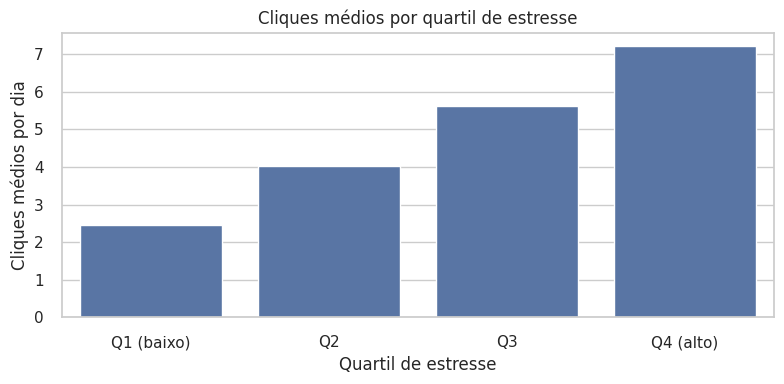

In [34]:
# Criação dos quartis de estresse
df_q = df_silver.copy()
df_q["stress_q"] = pd.qcut(
    df_q["perceived_stress_score"],
    4,
    labels=["Q1 (baixo)", "Q2", "Q3", "Q4 (alto)"]
)

# Média de cliques por quartil de estresse
stress_mean = (
    df_q
    .groupby("stress_q", observed=True)["ads_clicked_per_day"]
    .mean()
    .reset_index()
)

# Garantir ordem correta dos quartis
stress_mean["stress_q"] = pd.Categorical(
    stress_mean["stress_q"],
    categories=["Q1 (baixo)", "Q2", "Q3", "Q4 (alto)"],
    ordered=True
)
stress_mean = stress_mean.sort_values("stress_q")

# Gráfico
plt.figure(figsize=(8, 4))
sns.barplot(
    data=stress_mean,
    x="stress_q",
    y="ads_clicked_per_day"
)
plt.title("Cliques médios por quartil de estresse")
plt.xlabel("Quartil de estresse")
plt.ylabel("Cliques médios por dia")
plt.tight_layout()
plt.show()

Observa-se uma relação positiva entre nível de estresse e cliques em anúncios. À medida que os usuários avançam dos quartis mais baixos de estresse (Q1) para os mais altos (Q4), a média de cliques por dia aumenta de forma consistente.

Esse comportamento sugere que usuários mais estressados tendem a interagir mais com anúncios, possivelmente por maior exposição, impulsividade ou busca por estímulos externos. No contexto da camada silver, o gráfico evidencia que a variável `perceived_stress_score` possui influência relevante no comportamento de clique e deve ser considerada em tratamentos e modelagens na camada Silver.


## 15. Cliques vs felicidade (barras por quartis)

Esta análise replica a lógica por quartis, agora para felicidade auto-relatada. A intenção é identificar se bem-estar subjetivo possui associação com propensão a clicar em anúncios, novamente sem assumir causalidade.

Uma tendência crescente indica que usuários mais felizes clicam mais; uma tendência decrescente indica que usuários mais felizes clicam menos. Ambos os sentidos são informativos.


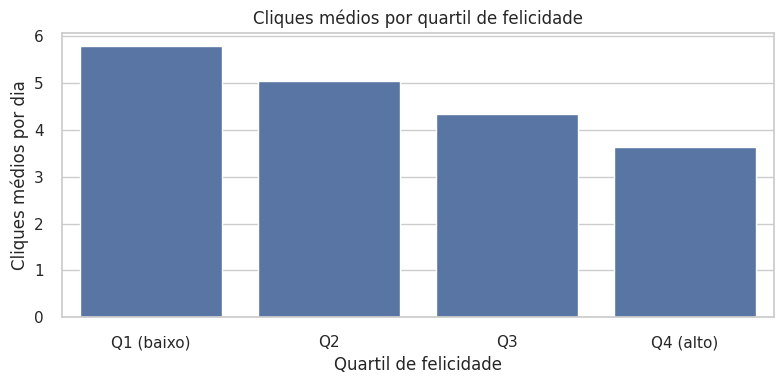

In [36]:
# Quartis de felicidade (sem warning e com ordem garantida)
df_q = df_silver.copy()
df_q["happy_q"] = pd.qcut(
    df_q["self_reported_happiness"],
    4,
    labels=["Q1 (baixo)", "Q2", "Q3", "Q4 (alto)"]
)

happy_mean = (
    df_q
    .groupby("happy_q", observed=True)["ads_clicked_per_day"]
    .mean()
    .reset_index()
)

# Garantir ordem Q1 -> Q4
happy_mean["happy_q"] = pd.Categorical(
    happy_mean["happy_q"],
    categories=["Q1 (baixo)", "Q2", "Q3", "Q4 (alto)"],
    ordered=True
)
happy_mean = happy_mean.sort_values("happy_q")

# Gráfico
plt.figure(figsize=(8, 4))
sns.barplot(
    data=happy_mean,
    x="happy_q",
    y="ads_clicked_per_day"
)
plt.title("Cliques médios por quartil de felicidade")
plt.xlabel("Quartil de felicidade")
plt.ylabel("Cliques médios por dia")
plt.tight_layout()
plt.show()

O gráfico indica uma relação inversa entre felicidade autorrelatada e cliques em anúncios. Conforme avançamos de Q1 (menor felicidade) para Q4 (maior felicidade), a média de cliques por dia diminui.

Esse padrão sugere que usuários menos satisfeitos tendem a clicar mais em anúncios, enquanto usuários mais felizes apresentam menor propensão ao clique. Na camada silver, isso reforça que `self_reported_happiness` é uma variável relevante para análises e modelagens na camada Silver.


## 16. Resultado Final da Análise Exploratória

A análise exploratória do dataset revelou padrões consistentes e estruturalmente sólidos sobre o comportamento de cliques em anúncios, permitindo conclusões claras quanto à qualidade dos dados, distribuição da variável alvo e fatores associados ao engajamento.

Do ponto de vista **estrutural**, o dataset apresenta alta qualidade: não foram identificados valores nulos em nenhuma coluna, o que elimina a necessidade de imputação ou descarte de registros por ausência de dados. Isso indica que a camada silver já é confiável quanto à completude, embora ainda demande transformações estatísticas na camada Silver.

A variável **ads_clicked_per_day** apresenta uma **distribuição assimétrica à direita**, com concentração de usuários em valores baixos de cliques e uma cauda longa de usuários com comportamento muito acima da média. Essa assimetria foi confirmada tanto pelo histograma quanto pelo boxplot, que evidenciam a presença de **outliers legítimos**, associados a perfis altamente ativos. Esses valores não configuram erro, mas indicam a necessidade de técnicas como winsorização, truncamento por percentis ou modelagens robustas.

A análise de **desbalanceamento (0 vs >0)** mostrou que a grande maioria dos usuários realiza ao menos um clique por dia, enquanto a classe de usuários que não clica é significativamente menor. Esse cenário caracteriza um fenômeno típico de *zero-inflation*, relevante para decisões de modelagem e avaliação de métricas preditivas.

As análises por **variáveis categóricas demográficas e socioeconômicas** (país, status de trabalho, presença de filhos e nível educacional) indicaram **diferenças pouco expressivas nas médias de cliques**. Os gráficos de barras mostraram valores muito próximos entre categorias, sugerindo que essas variáveis, isoladamente, não exercem influência significativa sobre a quantidade média de cliques no nível bruto dos dados.

Em contrapartida, as análises por **faixas etárias** mostraram uma tendência clara: usuários mais jovens apresentam médias de cliques ligeiramente maiores, com redução gradual conforme o aumento da idade. Ainda assim, a variação não é abrupta, indicando um efeito moderado.

As análises por **quartis de estresse e felicidade** revelaram padrões comportamentais mais relevantes. Observou-se uma **relação positiva entre estresse e cliques**, com aumento progressivo da média de cliques do quartil mais baixo para o mais alto de estresse. Já para felicidade, a relação foi **negativa**, indicando que usuários menos felizes tendem a clicar mais em anúncios. Esses resultados sugerem associações comportamentais consistentes, embora não impliquem causalidade.

A **matriz de correlação** reforçou esses achados, destacando fortes correlações positivas entre cliques e variáveis de exposição à plataforma, como tempo ativo, anúncios visualizados e tempo no feed. Por outro lado, variáveis como engajamento orgânico, felicidade e idade apresentaram correlações negativas ou fracas, enquanto hábitos como leitura, hobbies e eventos sociais mostraram correlação praticamente nula.

### Conclusão Geral

O comportamento de cliques em anúncios é fortemente explicado por **exposição e uso da plataforma**, moderadamente associado a **aspectos psicossociais** (estresse e felicidade) e pouco influenciado por **características demográficas tradicionais** quando analisadas isoladamente. O dataset é estruturalmente consistente, porém apresenta **assimetria, outliers e desbalanceamento**, justificando tratamentos estatísticos e modelagens cuidadosas na camada Silver para análises mais robustas e preditivas.
